In [107]:
import os, joblib
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import torch
import torch.distributed as dist 
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# !cd /kaggle/working/models/
# !rm -rf *

In [3]:
# !mkdir models
# !ls /kaggle/working/models/
!ls /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [108]:
!ls /kaggle/input/pashto-poetry/data/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


abbasinYousuf	karanKhan	    mumtazOrakazi   salimRiaz
ajmalKhattak	khaliqZiari	    munirJan	    shabbirKhanDurrani
allamaAbdulHai	khatirAfridi	    naeemAhmed	    shakirOrakzai
azizMazerwal	khayyamYousufzai    rabiaMumtaz     shoaibKhanKhattak
ghaniKhan	khushalKhanKhattak  rahmanBaba
hamzaBaba	matiullahTurab	    rehmatShah
javedAhmedzai	mohammadAjanyar     sahibShahSabir


In [109]:
# Define Data directory
DATA_DIR = '/kaggle/input/pashto-poetry/data/'

# list of poet names
# Removed the 5 lowest poets
poets = ["abbasinYousuf", "ajmalKhattak", "allamaAbdulHai", "ghaniKhan", "hamzaBaba", "javedAhmedzai", "karanKhan", "khatirAfridi", "khushalKhanKhattak", "matiullahTurab", "mumtazOrakazi", "munirJan", "naeemAhmed", "rabiaMumtaz", "rahmanBaba", "rehmatShah", "sahibShahSabir", "shabbirKhanDurrani", "shakirOrakzai", "shoaibKhanKhattak"]

poet_labels = {poet: i for i, poet in enumerate(poets)}
print(poet_labels)

{'abbasinYousuf': 0, 'ajmalKhattak': 1, 'allamaAbdulHai': 2, 'ghaniKhan': 3, 'hamzaBaba': 4, 'javedAhmedzai': 5, 'karanKhan': 6, 'khatirAfridi': 7, 'khushalKhanKhattak': 8, 'matiullahTurab': 9, 'mumtazOrakazi': 10, 'munirJan': 11, 'naeemAhmed': 12, 'rabiaMumtaz': 13, 'rahmanBaba': 14, 'rehmatShah': 15, 'sahibShahSabir': 16, 'shabbirKhanDurrani': 17, 'shakirOrakzai': 18, 'shoaibKhanKhattak': 19}


In [160]:
# Load and Label the Data
def load_and_label(data_dir, poets, poet_labels):
    data = []
    labels = []

    for poet in poets:
        poet_dir = os.path.join(data_dir, poet)
        file_path = os.path.join(poet_dir, f'{poet}.txt')

        # Check if the file exists
        if not os.path.exists(file_path):
            print(f'{file_path} does not exist')
            continue

        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            poem = " ".join([line.strip() for line in lines if line.strip()])
            data.extend(lines)
            labels.extend([poet_labels[poet]] * len(lines))

    df = pd.DataFrame({'text': data, 'label': labels})
    return data, labels, df

# # Load and Label the Data
# def load_and_label(data_dir, poets, poet_labels):
#     data = []
#     labels = []

#     for poet in poets:
#         poet_dir = os.path.join(data_dir, poet)
#         file_path = os.path.join(poet_dir, f'{poet}.txt')

#         # Check if the file exists
#         if not os.path.exists(file_path):
#             print(f'{file_path} does not exist')
#             continue

#         with open(file_path, 'r', encoding='utf-8') as f:
#             lines = f.readlines()
#             data.extend(lines)
#             labels.extend([poet_labels[poet]] * len(lines))

#     df = pd.DataFrame({'text': data, 'label': labels})
#     return data, labels, df

In [161]:
data, labels, df = load_and_label(DATA_DIR, poets, poet_labels)
df.describe()

label
count  54620.000000
mean       8.625265
std        5.352617
min        0.000000
25%        4.000000
50%        8.000000
75%       14.000000
max       19.000000

In [ ]:
# Load model directly
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-uncased")
# # padding token
# tokenizer.pad_token = tokenizer.eos_token

In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [145]:
poems_train, poems_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

In [19]:
# # Function to save embeddings
# def save_embeddings(texts, prefix, model, tokenizer, device, max_length=80):
#     for i, text in enumerate(texts):
#         inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
#         inputs = {key: val.to(device) for key, val in inputs.items()}
        
#         with torch.no_grad():
#             outputs = model(**inputs, output_hidden_states=True)
#             # Use the mean of the last hidden state as the embedding
#             embedding = outputs.hidden_states[-1].mean(dim=1).to(device)
        
#         torch.save(embedding, f'./models_llama/{prefix}_embedding_{i}.pt')
#         if i % 100 == 0:
#             print(f"{prefix.capitalize()} Embedding {i} saved.")


In [ ]:
# Save embeddings for train, test and validation
save_embeddings(poems_train, 'train', model, tokenizer, device)
save_embeddings(poems_val, 'val', model, tokenizer, device)
save_embeddings(poems_test, 'test', model, tokenizer, device)

In [162]:
!ls ../../kaggle/input/bert-embeddings/pytorch/default/1/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


models_bert


In [201]:
class_labels = sorted(list(set(lables_train)))

def load_embeddings(prefix, num_embeddings):
    embeddings = []
    for i in range(num_embeddings):
        embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{prefix}_embedding_{i}.pt')
        embeddings.append(embedding)
    return torch.stack(embeddings)

In [202]:
train_embeddings = load_embeddings('train', len(poems_train))
train_embeddings

/tmp/ipykernel_30/1379991780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{p

tensor([[[-0.1905, -0.1747, -0.0373,  ...,  0.1524,  0.0355, -0.4863]],

        [[-0.2087,  0.3217,  0.1432,  ...,  0.1399, -0.1742, -0.5643]],

        [[-0.3166,  0.0294,  0.0139,  ...,  0.1276, -0.0290, -0.7633]],

        ...,

        [[-0.2490, -0.0561,  0.2666,  ...,  0.1979,  0.0955, -0.7329]],

        [[-0.1643, -0.2385,  0.1733,  ...,  0.0104,  0.2309, -0.8042]],

        [[-0.3224, -0.2890,  0.2191,  ...,  0.2276, -0.1486, -0.6660]]])

In [203]:
val_embeddings = load_embeddings('val', len(poems_val))
val_embeddings

/tmp/ipykernel_30/1379991780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{p

tensor([[[-0.1757, -0.0679,  0.1288,  ..., -0.1309,  0.1214, -0.7471]],

        [[-0.1916, -0.1739,  0.2034,  ...,  0.2056,  0.0452, -0.5120]],

        [[-0.1839,  0.2615,  0.1037,  ...,  0.4120, -0.1733, -0.5369]],

        ...,

        [[-0.1588, -0.6373,  0.2744,  ...,  0.4202, -0.2921, -0.4001]],

        [[-0.0924, -0.3633,  0.2798,  ...,  0.2451,  0.0631, -0.4194]],

        [[-0.0419,  0.2387, -0.1577,  ...,  0.2545, -0.0347, -0.4790]]])

In [204]:
test_embeddings = load_embeddings('test', len(poems_test))
test_embeddings

/tmp/ipykernel_30/1379991780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{p

tensor([[[-0.1855,  0.4097,  0.0779,  ...,  0.1855,  0.0964, -0.8585]],

        [[-0.2312,  0.1186,  0.0410,  ...,  0.3333,  0.1029, -0.2986]],

        [[-0.1937, -0.0553,  0.1295,  ...,  0.1498,  0.0413, -0.8281]],

        ...,

        [[-0.1352,  0.1036,  0.2675,  ...,  0.1964,  0.1506, -0.8558]],

        [[-0.0597,  0.2519,  0.1869,  ...,  0.1443, -0.0341, -0.4994]],

        [[-0.2132, -0.4385,  0.2612,  ...,  0.3508, -0.2449, -0.7415]]])

In [289]:
train_labels = torch.tensor(labels_train)
val_labels = torch.tensor(labels_val)
test_labels = torch.tensor(labels_test)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# encoded_labels = label_encoder.fit_transform(lables_train)

In [290]:
train_embeddings_np = train_embeddings.cpu().detach().numpy()
val_embeddings_np = val_embeddings.cpu().detach().numpy()
test_embeddings_np = test_embeddings.cpu().detach().numpy()
labels_train_np = np.array(labels_train)
# labels_train_np = np.array(poems_train)
labels_val_np = np.array(labels_val)
labels_test_np = np.array(labels_test)

In [291]:
train_embeddings_np.shape, val_embeddings_np.shape, test_embeddings_np.shape, labels_train_np.shape, labels_val_np.shape, labels_test_np.shape

((43696, 1, 768), (5462, 1, 768), (5462, 1, 768), (43696,), (5462,), (5462,))

In [292]:
class PoemClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoemClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, output_size)
        self.drop = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# #BERT WITH BERT

# class PoemClassifier(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(PoemClassifier, self).__init__()
#         self.fc = nn.Linear(input_size, output_size)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Flatten along the sequence length dimension
#         x = F.relu(x)
#         x = self.fc(x)
#         return x

In [293]:
# Set the input size based on the size of the embeddings
input_size = train_embeddings.size(2)  # Use size(2) instead of size(1)

# Initialize the classifier and move it to the device
classifier = PoemClassifier(input_size, len(set(labels)))
classifier.to(device)

# # Define the optimizer and loss function
# optimizer = optim.Adam(classifier.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# Define the optimizer and loss function
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# # Define the optimizer and loss function
# optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
# criterion = nn.CrossEntropyLoss()

# # Define the optimizer and loss function
# optimizer = optim.RMSprop(classifier.parameters(), lr=0.001, alpha=0.9)
# criterion = nn.CrossEntropyLoss()

# Create DataLoader for training to iterate over the embeddings and labels in batches.
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# # set the input size based on the size of the embeddings
# input_size = train_embeddings.size(2)

# # initialize the classifier and move it to the device
# classifier = PoemClassifier(input_size, len(labels)).to(device)
# # classifier = PoemClassifier(input_size, len(class_labels)).to(device)
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     classifier = nn.DataParallel(classifier)

# # Define the optimizer and loss function
# optimizer = optim.Adam(classifier.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# # Create dataloader for training to iterate over the embeddings and labels in batches
# train_dataset = TensorDataset(train_embeddings, train_labels)
# # train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [294]:
torch.cuda.device_count()

2

In [295]:
val_accuracies = []
train_accuracies = []
best_val_loss = float('inf')
patience = 5  # You can adjust this based on your needs
counter = 0
train_losses = []  # Track training loss
val_losses = []

In [296]:
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(TensorDataset(val_embeddings, val_labels), batch_size = 8)
# accumalation_steps = 4
# Create DataLoader for training to iterate over the embeddings and labels in batches.
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [297]:
# train_loader, val_loader
train_loader

In [298]:
# Training loop with early stopping
num_epochs = 100
for epoch in range(num_epochs):
    classifier.train()
    epoch_loss=0

    for batch_embeddings, batch_labels in train_loader:
      batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

      # Forward pass
      outputs = classifier(batch_embeddings)
      loss = criterion(outputs, batch_labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    # Average training loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Training accuracy
    with torch.no_grad():
        classifier.eval()
        train_outputs = classifier(train_embeddings.to(device))
        train_probabilities = F.softmax(train_outputs, dim=1)
        train_predicted_labels = torch.argmax(train_probabilities, dim=1).tolist()
        train_accuracy = accuracy_score(train_labels, train_predicted_labels)
        train_accuracies.append(train_accuracy)
    # Validation
    with torch.no_grad():
        classifier.eval()
        val_outputs = classifier(val_embeddings.to(device))
        val_loss = criterion(val_outputs, val_labels.to(device))
        val_losses.append(val_loss.item())


        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1


        val_probabilities = F.softmax(val_outputs, dim=1)
        val_predicted_labels = torch.argmax(val_probabilities, dim=1).tolist()
        val_accuracy = accuracy_score(val_labels, val_predicted_labels)
        val_accuracies.append(val_accuracy)

        # Print the current status
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered!")
            break

# # Train Loop with early stopping
# num_epochs = 20
# for epoch in range(num_epochs):
#     classifier.train()
#     epoch_loss = 0
#     optimizer.zero_grad()

#     for i, (batch_embeddings, batch_labels) in enumerate(train_loader):
#         if i % 100 == 0: print(f"Iteration {i}/{len(train_loader)} of train loader")
#         batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

#         # optimizer.zero_grad()
#         output = classifier(batch_embeddings)
#         loss = criterion(output, batch_labels)
#         # loss.backward()
#         loss = loss / accumalation_steps
#         loss.backward()
#         # optimizer.step()

#         if (i + 1) % accumalation_steps == 0 or (i + 1) == len(train_loader):
#             optimizer.step()
#             optimizer.zero_grad()
#             epoch_loss += loss.item() * accumalation_steps

#     avg_epoch_loss = epoch_loss / len(train_loader.dataset)
#     train_losses.append(avg_epoch_loss)

#     print(f"Epoch {epoch + 1}/{num_epochs} - Training and Validation Accuracy:")

#     # Training accuracy and data in batches to avoid over memory consumption
#     classifier.eval()
#     train_correct = 0
#     train_total = 0
#     with torch.no_grad():
#         for batch_embeddings, batch_labels in train_loader:
#             batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
#             train_outputs = classifier(batch_embeddings)
#             train_probabilities = F.softmax(train_outputs, dim=1)
#             train_predicted_labels = torch.argmax(train_probabilities, dim=1)
#             train_correct += (train_predicted_labels == batch_labels).sum().item()
#             train_total += batch_labels.size(0)
#     train_accuracy = train_correct / train_total
#     train_accuracies.append(train_accuracy)


#     # Validation accuracy and loss in batches to avoid over memory consumption
#     val_correct = 0
#     val_total = 0
#     val_loss_total = 0
#     with torch.no_grad():
#         for val_batch_embeddings, val_batch_labels in DataLoader(TensorDataset(val_embeddings, val_labels), batch_size=8):
#             val_batch_embeddings, val_batch_labels = val_batch_embeddings.to(device), val_batch_labels.to(device)
#             val_outputs = classifier(val_batch_embeddings)
#             val_loss = criterion(val_outputs, val_batch_labels)
#             val_loss_total += val_loss.item()

#             val_probabilities = F.softmax(val_outputs, dim=1)
#             val_predicted_labels = torch.argmax(val_probabilities, dim=1)
#             val_correct += (val_predicted_labels == val_batch_labels).sum().item()
#             val_total += val_batch_labels.size(0)

#         val_accuracy = val_correct / val_total
#         val_accuracies.append(val_accuracy)
#         val_losses.append(val_loss_total / len(val_loader))
        

#     # Print current status
#     print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss_total / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

#     # Early stopping check
#     if val_loss_total < best_val_loss:
#         best_val_loss = val_loss_total
#         counter = 0
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early Stopping!")
#             break

Epoch [1/100], Loss: 2.1565, Validation Loss: 1.8900
Epoch [2/100], Loss: 1.8422, Validation Loss: 1.8232
Epoch [3/100], Loss: 1.0854, Validation Loss: 1.7809
Epoch [4/100], Loss: 1.1898, Validation Loss: 1.7598
Epoch [5/100], Loss: 1.3824, Validation Loss: 1.7218
Epoch [6/100], Loss: 0.9552, Validation Loss: 1.7003
Epoch [7/100], Loss: 1.1210, Validation Loss: 1.6879
Epoch [8/100], Loss: 1.6297, Validation Loss: 1.6816
Epoch [9/100], Loss: 1.7714, Validation Loss: 1.6709
Epoch [10/100], Loss: 2.4009, Validation Loss: 1.6669
Epoch [11/100], Loss: 1.8634, Validation Loss: 1.6575
Epoch [12/100], Loss: 1.8562, Validation Loss: 1.6479
Epoch [13/100], Loss: 1.6991, Validation Loss: 1.6504
Epoch [14/100], Loss: 1.2308, Validation Loss: 1.6509
Epoch [15/100], Loss: 1.4282, Validation Loss: 1.6537
Epoch [16/100], Loss: 2.2015, Validation Loss: 1.6407
Epoch [17/100], Loss: 1.1395, Validation Loss: 1.6886
Epoch [18/100], Loss: 0.9534, Validation Loss: 1.6311
Epoch [19/100], Loss: 1.4366, Validat

In [301]:
# evaluation on the test set
with torch.no_grad():
    classifier.eval()
    test_outputs = classifier(test_embeddings.to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))

    # convert logits to probs
    test_probabilities = F.softmax(test_outputs, dim=1)

    # get the predicted labels
    test_predicted_labels = torch.argmax(test_probabilities, dim=1).tolist()

    cm = confusion_matrix(test_labels, test_predicted_labels)

    # calculate the accuracy
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    test_loss_value = test_loss.item()

Test Accuracy: 0.4925


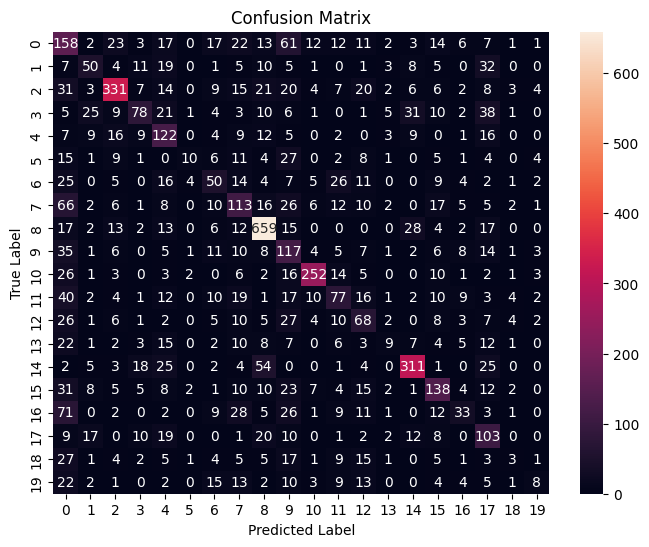

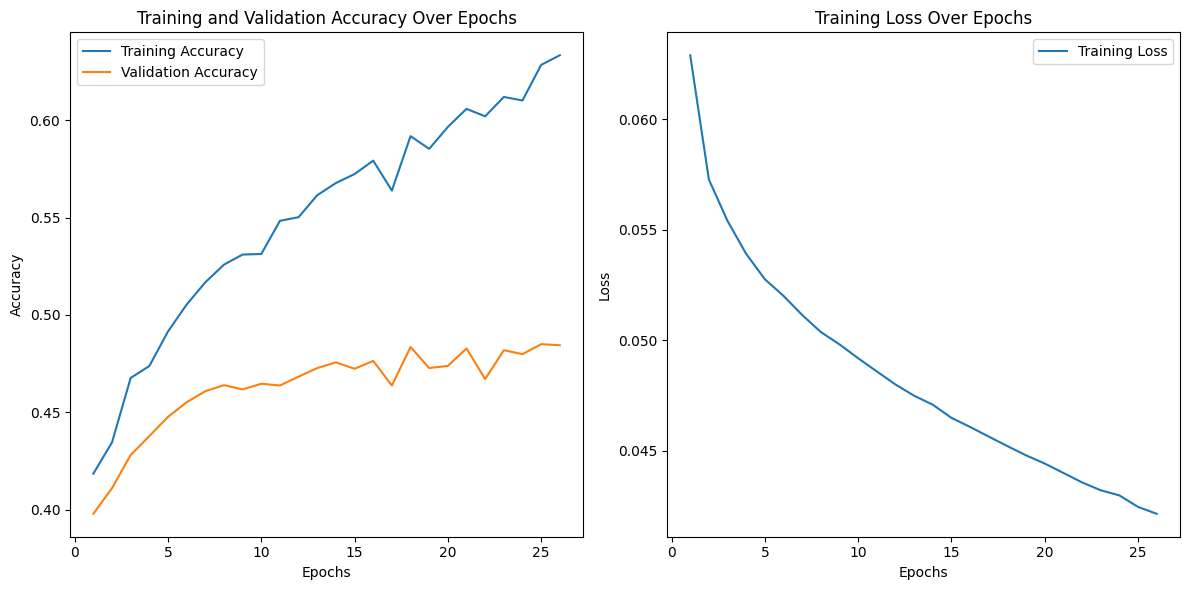

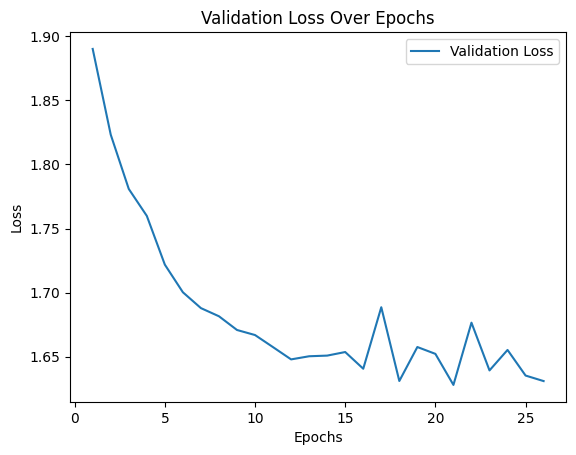

In [302]:
# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plot accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
# plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# BERT TESTING DUBARA PHIRSE

In [34]:
poems_train, poems_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=0.2, random_state=42)
poems_val, poems_test, labels_val, labels_test = train_test_split(poems_temp, labels_temp, test_size=0.5, random_state=42)

In [37]:
class_labels = sorted(list(set(lables_train)))

def load_embeddings(prefix, num_embeddings):
    embeddings = []
    for i in range(num_embeddings):
        embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{prefix}_embedding_{i}.pt')
        embeddings.append(embedding)
    return torch.stack(embeddings)

In [39]:
train_embeddings = load_embeddings('train', len(poems_train))
val_embeddings = load_embeddings('val', len(poems_val))
test_embeddings = load_embeddings('test', len(poems_test))

/tmp/ipykernel_30/1379991780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(f'../../kaggle/input/bert-embeddings/pytorch/default/1/models_bert/{p

In [40]:
train_embeddings, val_embeddings, test_embeddings

(tensor([[[-0.1905, -0.1747, -0.0373,  ...,  0.1524,  0.0355, -0.4863]],
 
         [[-0.2087,  0.3217,  0.1432,  ...,  0.1399, -0.1742, -0.5643]],
 
         [[-0.3166,  0.0294,  0.0139,  ...,  0.1276, -0.0290, -0.7633]],
 
         ...,
 
         [[-0.2490, -0.0561,  0.2666,  ...,  0.1979,  0.0955, -0.7329]],
 
         [[-0.1643, -0.2385,  0.1733,  ...,  0.0104,  0.2309, -0.8042]],
 
         [[-0.3224, -0.2890,  0.2191,  ...,  0.2276, -0.1486, -0.6660]]]),
 tensor([[[-0.1757, -0.0679,  0.1288,  ..., -0.1309,  0.1214, -0.7471]],
 
         [[-0.1916, -0.1739,  0.2034,  ...,  0.2056,  0.0452, -0.5120]],
 
         [[-0.1839,  0.2615,  0.1037,  ...,  0.4120, -0.1733, -0.5369]],
 
         ...,
 
         [[-0.1588, -0.6373,  0.2744,  ...,  0.4202, -0.2921, -0.4001]],
 
         [[-0.0924, -0.3633,  0.2798,  ...,  0.2451,  0.0631, -0.4194]],
 
         [[-0.0419,  0.2387, -0.1577,  ...,  0.2545, -0.0347, -0.4790]]]),
 tensor([[[-0.1855,  0.4097,  0.0779,  ...,  0.1855,  0.0964, -0.858

In [57]:
# Convert labels to PyTorch tensors
train_labels = torch.tensor(labels_train)
val_labels = torch.tensor(labels_val)
test_labels = torch.tensor(labels_test)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

train_embeddings_np = train_embeddings.detach().numpy()
val_embeddings_np = val_embeddings.detach().numpy()
test_embeddings_np = test_embeddings.detach().numpy()
labels_train_np = np.array(labels_train)
labels_val_np = np.array(labels_val)
labels_test_np = np.array(labels_test)

In [58]:
#BERT WITH BERT

class PoemClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(PoemClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten along the sequence length dimension
        x = F.relu(x)
        x = self.fc(x)
        return x

In [59]:
# Set the input size based on the size of the embeddings
input_size = train_embeddings.size(2)  # Use size(2) instead of size(1)

# Initialize the classifier and move it to the device
classifier = PoemClassifier(input_size, len(set(labels)))
classifier.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create DataLoader for training to iterate over the embeddings and labels in batches.
train_dataset = TensorDataset(train_embeddings, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [60]:
# ... (previous code remains unchanged)
val_accuracies = []
train_accuracies = []
best_val_loss = float('inf')
patience = 5  # You can adjust this based on your needs
counter = 0
train_losses = []  # Track training loss
val_losses = []

In [61]:
# Training loop with early stopping
num_epochs = 50
for epoch in range(num_epochs):
    classifier.train()
    epoch_loss=0

    for batch_embeddings, batch_labels in train_loader:
      batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

      # Forward pass
      outputs = classifier(batch_embeddings)
      loss = criterion(outputs, batch_labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

    # Average training loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    # Training accuracy
    with torch.no_grad():
        classifier.eval()
        train_outputs = classifier(train_embeddings.to(device))
        train_probabilities = F.softmax(train_outputs, dim=1)
        train_predicted_labels = torch.argmax(train_probabilities, dim=1).tolist()
        train_accuracy = accuracy_score(train_labels, train_predicted_labels)
        train_accuracies.append(train_accuracy)
    # Validation
    with torch.no_grad():
        classifier.eval()
        val_outputs = classifier(val_embeddings.to(device))
        val_loss = criterion(val_outputs, val_labels.to(device))
        val_losses.append(val_loss.item())


        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1


        val_probabilities = F.softmax(val_outputs, dim=1)
        val_predicted_labels = torch.argmax(val_probabilities, dim=1).tolist()
        val_accuracy = accuracy_score(val_labels, val_predicted_labels)
        val_accuracies.append(val_accuracy)

        # Print the current status
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered!")
            break

Epoch [1/50], Loss: 2.1226, Validation Loss: 2.0661
Epoch [2/50], Loss: 2.1359, Validation Loss: 1.9660
Epoch [3/50], Loss: 1.8441, Validation Loss: 1.9127
Epoch [4/50], Loss: 2.2960, Validation Loss: 1.8807
Epoch [5/50], Loss: 1.4819, Validation Loss: 1.8575
Epoch [6/50], Loss: 1.3660, Validation Loss: 1.8404
Epoch [7/50], Loss: 1.6379, Validation Loss: 1.8255
Epoch [8/50], Loss: 1.6670, Validation Loss: 1.8159
Epoch [9/50], Loss: 1.9840, Validation Loss: 1.8076
Epoch [10/50], Loss: 2.0515, Validation Loss: 1.8050
Epoch [11/50], Loss: 2.1889, Validation Loss: 1.7968
Epoch [12/50], Loss: 1.7028, Validation Loss: 1.7918
Epoch [13/50], Loss: 2.0013, Validation Loss: 1.7922
Epoch [14/50], Loss: 1.8743, Validation Loss: 1.7848
Epoch [15/50], Loss: 1.8901, Validation Loss: 1.7758
Epoch [16/50], Loss: 1.2337, Validation Loss: 1.7739
Epoch [17/50], Loss: 1.2404, Validation Loss: 1.7742
Epoch [18/50], Loss: 1.2214, Validation Loss: 1.7718
Epoch [19/50], Loss: 1.5292, Validation Loss: 1.7679
Ep

In [62]:
# Evaluation on the test set
with torch.no_grad():
    classifier.eval()
    test_outputs = classifier(test_embeddings.to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))

    # Convert logits to probabilities
    test_probabilities = F.softmax(test_outputs, dim=1)

    # Get the predicted labels
    test_predicted_labels = torch.argmax(test_probabilities, dim=1).tolist()

    cm = confusion_matrix(test_labels, test_predicted_labels)
    # Calculate accuracy for test set
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.4601


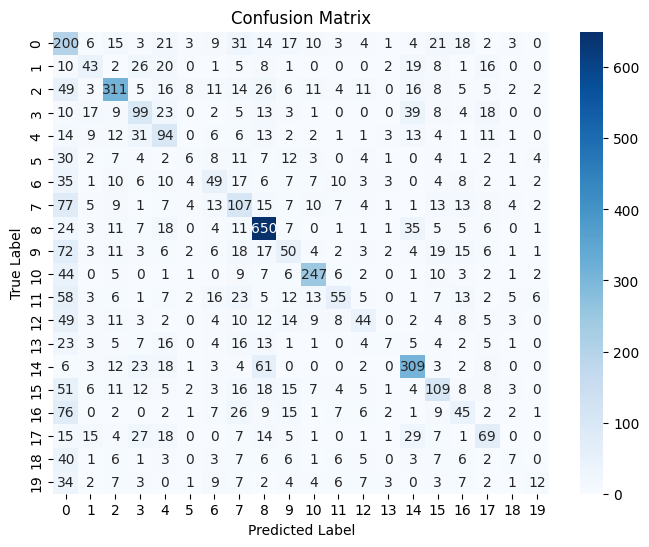

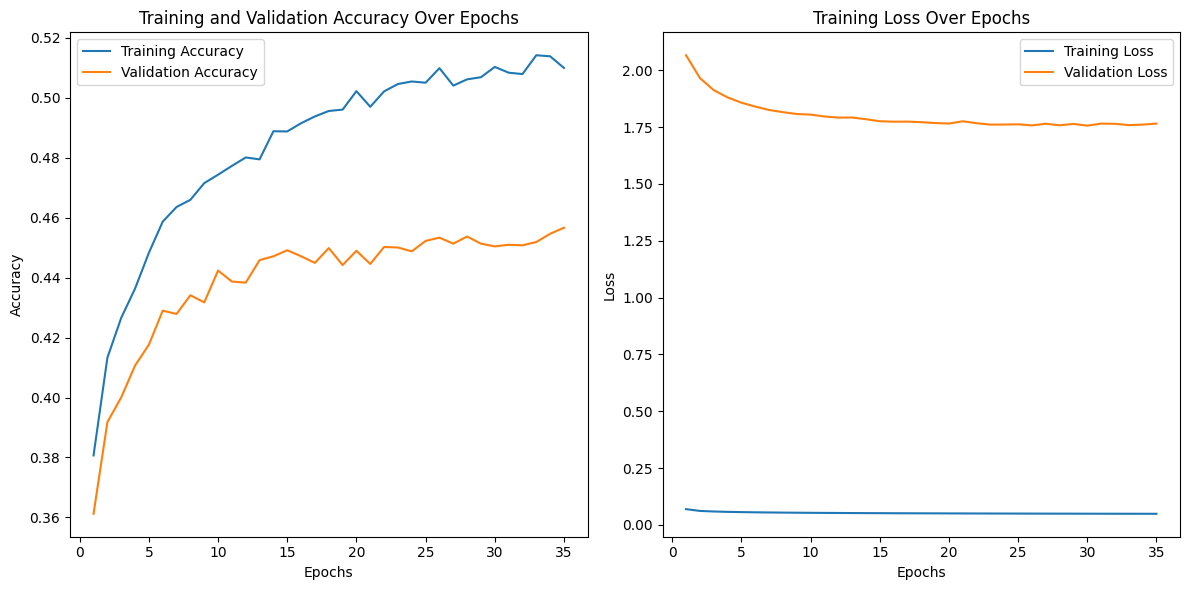

In [63]:
# Plot the confusion matrix
cm = confusion_matrix(labels_test_np, test_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Plot accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
# plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()